# IMPORTS

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# SETTINGS

In [2]:
SETTINGS = {
    "DATA_RUTE": r"data/",
    "DATA_VERSION_RUTE": r"data/original_data/",
    "DATA_VERSION": 3,
    
    "MODEL_SETTINGS":{
        "LAYER_SIZE": 128,
        "GENRE_THRESHOLD": 0.5,
    },
}

# DATA LOADING

In [3]:
if SETTINGS["DATA_VERSION"] == 0:
    column_names = [
        "wikipedia_movie_ID", 
        "freebase_movie_ID", 
        "name", 
        "release_date", 
        "box_office_revenue", 
        "runtime", 
        "languages", 
        "countries", 
        "genres"
    ]
    MOVIES = pd.read_csv(f'{SETTINGS["DATA_VERSION_RUTE"]}movie.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
elif SETTINGS["DATA_VERSION"] == 1: 
    MOVIES = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv')
    MOVIES = MOVIES.drop(columns=["homepage", "poster_path", "backdrop_path"])
    
elif SETTINGS["DATA_VERSION"] == 2: 
    column_names = [
        "name", 
        "rating", 
        "genre", 
        "release_year", 
        "status", 
        "score", 
        "votes", 
        "director", 
        "writer", 
        "star",
        "country", 
        "budget", 
        "box_office_revenue", 
        "company",
        "runtime", 
    ]
    MOVIES = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}movies.csv', names=column_names)
    MOVIES = MOVIES.drop(columns=["director", "writer", "star"])
    MOVIES = MOVIES.drop(MOVIES.index[0])
    
elif SETTINGS["DATA_VERSION"] == 3:
    column_names = [
        "wikipedia_movie_ID", 
        "freebase_movie_ID", 
        "name", 
        "release_date", 
        "revenue", 
        "runtime", 
        "languages", 
        "countries", 
        "genres"
    ]
    MOVIES_ORIGINAL = pd.read_csv(f'{SETTINGS["DATA_VERSION_RUTE"]}movie.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    column_names = [
        'id_new', 
        'title', 
        'vote_average', 
        'vote_count', 
        'status_new', 
        'release_date_new',
        'revenue_new', 
        'runtime_new', 
        'adult', 
        'backdrop_path', 
        'budget', 
        'homepage',
        'imdb_id', 
        'original_language', 
        'original_title', 
        'overview',
        'popularity', 
        'poster_path', 
        'tagline', 
        'genres_new',
        'production_companies', 
        'production_countries', 
        'spoken_languages',
        'keywords'
    ]
    MOVIES_NEW = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv', sep=',', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    
    MOVIES_ORIGINAL['name'] = MOVIES_ORIGINAL['name'].str.strip().str.lower()
    MOVIES_NEW['title'] = MOVIES_NEW['title'].str.strip().str.lower()
    
    MOVIES = pd.merge(MOVIES_ORIGINAL, MOVIES_NEW, left_on='name', right_on='title', how='left')
    MOVIES = MOVIES.drop(columns=[
        "id_new", "title", "status_new", "release_date_new", "revenue_new", "runtime_new", "imdb_id",
        "original_language", "original_title", "overview", "tagline", "genres_new", 'production_companies', 
        'production_countries', 'spoken_languages', 'keywords', "homepage", "poster_path", "backdrop_path"
    ])    
    
MOVIES.head()

/var/folders/ms/0_q4m69d3qs0hvrd_skkxzs80000gn/T/ipykernel_31246/2861577440.py:81: DtypeWarning: Columns (0,2,3,6,7,8,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  MOVIES_NEW = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv', sep=',', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)


,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,vote_average,vote_count,adult,budget,popularity
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",5.127,977,False,28000000,14.189
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",0.0,0,False,0,0.6
2,28463795,/m/0crgdbh,brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,NaN,NaN,NaN,NaN
3,9363483,/m/0285_cd,white of the eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",5.742,64,False,0,8.297
4,261236,/m/01mrr1,a woman in flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",5.3,13,False,0,2.801


In [6]:
column_names = [
    "Wikipedia movie ID",
    "Freebase movie ID",
    "Movie release date",
    "Character name",
    "Actor date of birth",
    "Actor gender",
    "Actor height (in meters)",
    "Actor ethnicity (Freebase ID)",
    "Actor name",
    "Actor age at movie release",
    "Freebase character/actor map ID",
    "Freebase character ID",
    "Freebase actor ID"
]
CHARACTER = pd.read_csv(f'{SETTINGS["DATA_VERSION_RUTE"]}character.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)

CHARACTER.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [7]:

female_actors = CHARACTER["Actor gender"].eq("F").sum()

male_actors = CHARACTER["Actor gender"].eq("M").sum()

#print(female_actors)
#print(male_actors)

#len(CHARACTER["Actor gender"])

MOVIES.head()



,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,vote_average,vote_count,adult,budget,popularity
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",5.127,977,False,28000000,14.189
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",0.0,0,False,0,0.6
2,28463795,/m/0crgdbh,brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,NaN,NaN,NaN,NaN
3,9363483,/m/0285_cd,white of the eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",5.742,64,False,0,8.297
4,261236,/m/01mrr1,a woman in flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",5.3,13,False,0,2.801


In [31]:
#BLANK

In [8]:
# Step 1: Count total characters for each movie in the CHARACTER DataFrame, including any potential missing entries
total_character_counts = CHARACTER.groupby('Wikipedia movie ID').size().reset_index(name='Character Count')

# Step 2: Drop existing 'Character Count' column in MOVIES if it exists to avoid conflict during the merge
if 'Character Count' in MOVIES.columns:
    MOVIES = MOVIES.drop(columns=['Character Count'])

# Step 3: Rename the 'Wikipedia movie ID' column in `total_character_counts` to avoid conflicts during merging
#total_character_counts = total_character_counts.rename(columns={'Wikipedia movie ID': 'movie_id_temp'})

# Step 4: Merge this data into MOVIES based on Wikipedia movie ID, filling missing values with 0
#MOVIES = MOVIES.merge(total_character_counts, left_on='wikipedia_movie_ID', right_on='movie_id_temp', how='left')
MOVIES = MOVIES.merge(total_character_counts, left_on='wikipedia_movie_ID', right_on='Wikipedia movie ID', how='left')
MOVIES['Character Count'] = MOVIES['Character Count'].fillna(0).astype(int)
MOVIES['Character Count'] = MOVIES['Character Count'].astype(int)

if 'Wikipedia movie ID' in MOVIES.columns:
    MOVIES = MOVIES.drop(columns=['Wikipedia movie ID'])

MOVIES.head()

,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,vote_average,vote_count,adult,budget,popularity,Character Count
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",5.127,977,False,28000000,14.189,17
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",0.0,0,False,0,0.6,15
2,28463795,/m/0crgdbh,brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,NaN,NaN,NaN,NaN,4
3,9363483,/m/0285_cd,white of the eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",5.742,64,False,0,8.297,2
4,261236,/m/01mrr1,a woman in flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",5.3,13,False,0,2.801,3


In [9]:
# Step 1: Create a helper column for counting NaN values in "Actor gender"
CHARACTER['Actor gender filled'] = CHARACTER['Actor gender'].fillna('N/A')

# Step 2: Use pivot_table to count occurrences of each gender per Wikipedia movie ID
actor_counts = CHARACTER.pivot_table(
    index='Wikipedia movie ID',
    columns='Actor gender filled',
    aggfunc='size',
    fill_value=0
).reset_index()

# Step 3: Rename columns for clarity
actor_counts = actor_counts.rename(columns={
    'M': 'Male actor count',
    'F': 'Female actor count',
    'N/A': 'N/A actor count'
})

# Display the resulting DataFrame
actor_counts.head()

Actor gender filled,Wikipedia movie ID,Female actor count,Male actor count,N/A actor count
0,330,4,0,0
1,3217,3,10,1
2,3333,6,8,0
3,3746,3,11,1
4,3837,2,18,0


In [10]:


# Step 3: Count male and female characters per movie based on `Wikipedia movie ID`
#gender_counts = CHARACTER.groupby(['Wikipedia movie ID', 'Actor gender']).size().unstack(fill_value=0)

if 'Male actor count' in MOVIES.columns:
    MOVIES = MOVIES.drop(columns=['Male actor count'])
if 'Female actor count' in MOVIES.columns:
    MOVIES = MOVIES.drop(columns=['Female actor count'])
if 'N/A actor count' in MOVIES.columns:
    MOVIES = MOVIES.drop(columns=['N/A actor count'])

# Rename columns to more meaningful names
#gender_counts.columns = ['Number of Female', 'Number of Male']

#gender_counts

# Step 4: Merge gender counts data back into the MOVIES DataFrame
MOVIES = MOVIES.merge(actor_counts, left_on='wikipedia_movie_ID', right_on='Wikipedia movie ID', how='left')

MOVIES['Male actor count'] = MOVIES['Male actor count'].fillna(0).astype(int)
MOVIES['Female actor count'] = MOVIES['Female actor count'].fillna(0).astype(int)
MOVIES['N/A actor count'] = MOVIES['N/A actor count'].fillna(0).astype(int)

if 'Wikipedia movie ID' in MOVIES.columns:
    MOVIES = MOVIES.drop(columns=['Wikipedia movie ID'])

# Step 5: Replace NaN values with 0 for movies with no female or male counts
#MOVIES['Number of Female'] = MOVIES['Number of Female'].fillna(0).astype(int)
#MOVIES['Number of Male'] = MOVIES['Number of Male'].fillna(0).astype(int)
#MOVIES['Number with no gender'] = MOVIES['Character Count']- MOVIES['Number of Female'] - MOVIES['Number of Male']  

# Step 7: Drop the extra 'Wikipedia movie ID' column from the merge, if not needed
#MOVIES = MOVIES.drop(columns=['Wikipedia movie ID'])

# Display the updated MOVIES DataFrame with the new columns
MOVIES.head()

,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,vote_average,vote_count,adult,budget,popularity,Character Count,Female actor count,Male actor count,N/A actor count
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",5.127,977,False,28000000,14.189,17,6,11,0
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",0.0,0,False,0,0.6,15,4,11,0
2,28463795,/m/0crgdbh,brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,NaN,NaN,NaN,NaN,4,2,2,0
3,9363483,/m/0285_cd,white of the eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",5.742,64,False,0,8.297,2,1,1,0
4,261236,/m/01mrr1,a woman in flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",5.3,13,False,0,2.801,3,1,2,0


In [11]:
print(MOVIES['wikipedia_movie_ID'].dtype)
print(CHARACTER['Wikipedia movie ID'].dtype)


int64
int64


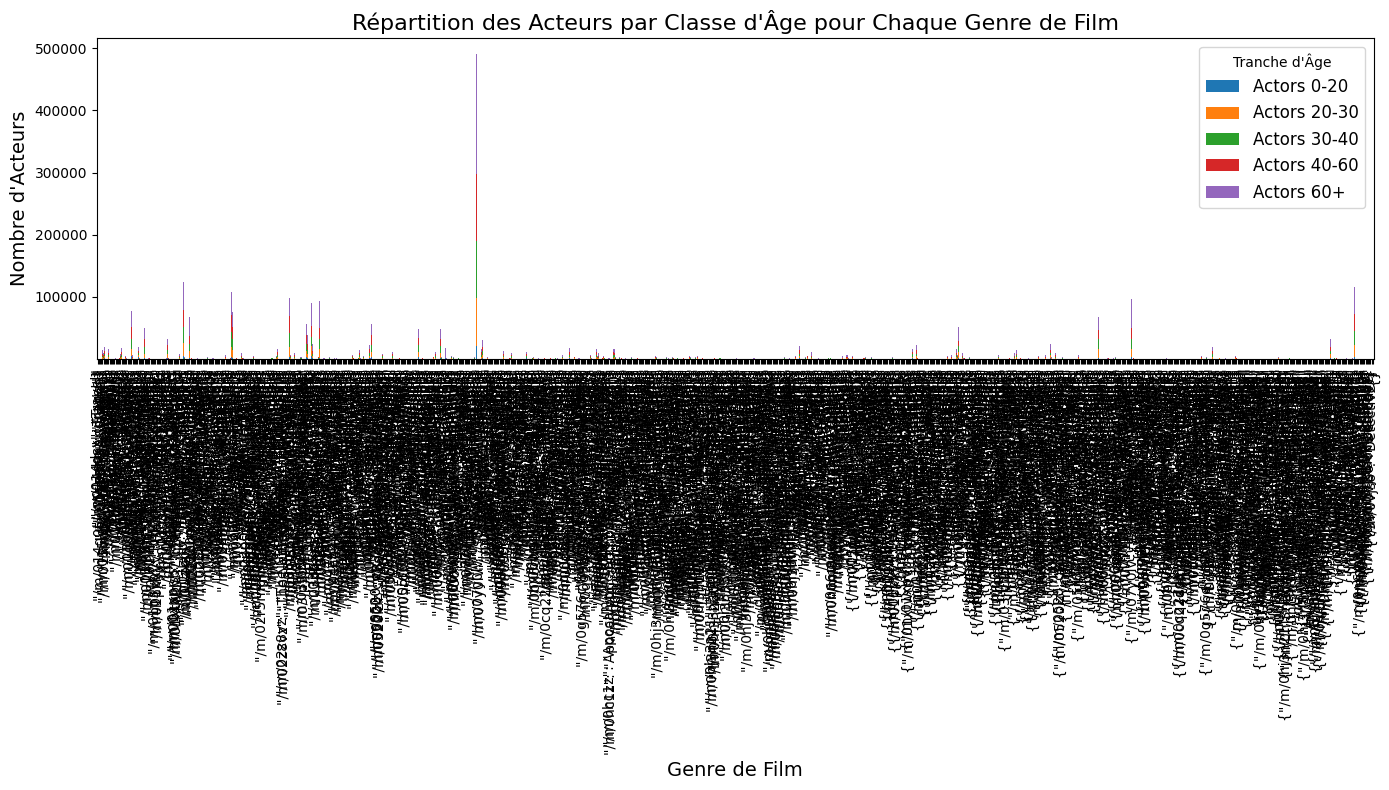

,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,vote_average,...,Actors 0-20_y,Actors 20-30_y,Actors 30-40_y,Actors 40-60_y,Actors 60+_y,Actors 0-20,Actors 20-30,Actors 30-40,Actors 40-60,Actors 60+
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",5.127,...,0.0,2.0,3.0,7.0,5.0,0,2,3,7,5
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",0.0,...,1.0,0.0,1.0,6.0,7.0,1,0,1,6,7
2,28463795,/m/0crgdbh,brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,...,0.0,1.0,2.0,1.0,0.0,0,1,2,1,0
3,9363483,/m/0285_cd,white of the eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",5.742,...,0.0,1.0,1.0,0.0,0.0,0,1,1,0,0
4,261236,/m/01mrr1,a woman in flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",5.3,...,0.0,0.0,3.0,0.0,0.0,0,0,3,0,0


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Étape 1 : Créer une nouvelle colonne 'age_range' dans CHARACTER pour catégoriser les âges
def categorize_age(age):
    if age < 20:
        return '0-20'
    elif 20 <= age < 30:
        return '20-30'
    elif 30 <= age < 40:
        return '30-40'
    elif 40 <= age < 60:
        return '40-60'
    else:
        return '60+'

# Appliquer la fonction de catégorisation d'âge
CHARACTER['age_range'] = CHARACTER['Actor age at movie release'].apply(categorize_age)

# Étape 2 : Compter le nombre d'acteurs par tranche d'âge pour chaque film
age_counts = CHARACTER.groupby(['Wikipedia movie ID', 'age_range']).size().unstack(fill_value=0)

# Renommer les colonnes pour correspondre aux tranches d'âge
age_counts.columns = ['Actors 0-20', 'Actors 20-30', 'Actors 30-40', 'Actors 40-60', 'Actors 60+']

# Étape 3 : Fusionner les données de comptage d'âge avec le DataFrame MOVIES
MOVIES = MOVIES.merge(age_counts, left_on='wikipedia_movie_ID', right_index=True, how='left')

# Remplir les valeurs NaN avec 0 pour les films qui n'ont pas d'acteurs dans certaines tranches d'âge
MOVIES[['Actors 0-20', 'Actors 20-30', 'Actors 30-40', 'Actors 40-60', 'Actors 60+']] = MOVIES[['Actors 0-20', 'Actors 20-30', 'Actors 30-40', 'Actors 40-60', 'Actors 60+']].fillna(0).astype(int)

# Étape 4 : Séparer les genres en lignes distinctes pour chaque genre de film
MOVIES['genres'] = MOVIES['genres'].fillna('')  # Remplacer les valeurs NaN dans 'genres' par une chaîne vide
MOVIES_GENRES = MOVIES.assign(genres=MOVIES['genres'].str.split(',')).explode('genres')

# Étape 5 : Supprimer les espaces autour des noms de genres pour éviter des doublons causés par des espaces
MOVIES_GENRES['genres'] = MOVIES_GENRES['genres'].str.strip()

# Étape 6 : Calculer le total d'acteurs par tranche d'âge et par genre
age_counts_by_genre = MOVIES_GENRES.groupby('genres')[['Actors 0-20', 'Actors 20-30', 'Actors 30-40', 'Actors 40-60', 'Actors 60+']].sum()

# Étape 7 : Tracer un histogramme empilé pour chaque genre de film
age_counts_by_genre.plot(kind='bar', stacked=True, figsize=(14, 8))

# Ajouter des titres et labels
plt.title("Répartition des Acteurs par Classe d'Âge pour Chaque Genre de Film", fontsize=16)
plt.xlabel("Genre de Film", fontsize=14)
plt.ylabel("Nombre d'Acteurs", fontsize=14)
plt.legend(title="Tranche d'Âge", fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.show()

MOVIES.head()


In [13]:
# Étape 1 : Créer une nouvelle colonne 'age_range' dans CHARACTER pour catégoriser les âges
def categorize_age(age):
    if age < 20:
        return '0-20'
    elif 20 <= age < 30:
        return '20-30'
    elif 30 <= age < 40:
        return '30-40'
    elif 40 <= age < 60:
        return '40-60'
    else:
        return '60+'

# Appliquer la fonction de catégorisation d'âge
CHARACTER['age_range'] = CHARACTER['Actor age at movie release'].apply(categorize_age)

# Étape 2 : Compter le nombre d'acteurs par tranche d'âge pour chaque film
age_counts = CHARACTER.groupby(['Wikipedia movie ID', 'age_range']).size().unstack(fill_value=0)

# Renommer les colonnes pour correspondre aux tranches d'âge
age_counts.columns = ['Actors 0-20', 'Actors 20-30', 'Actors 30-40', 'Actors 40-60', 'Actors 60+']

# Étape 3 : Fusionner les données de comptage d'âge avec le DataFrame MOVIES
MOVIES = MOVIES.merge(age_counts, left_on='wikipedia_movie_ID', right_index=True, how='left')

# Remplir les valeurs NaN avec 0 pour les films qui n'ont pas d'acteurs dans certaines tranches d'âge
MOVIES[['Actors 0-20', 'Actors 20-30', 'Actors 30-40', 'Actors 40-60', 'Actors 60+']] = MOVIES[['Actors 0-20', 'Actors 20-30', 'Actors 30-40', 'Actors 40-60', 'Actors 60+']].fillna(0).astype(int)

# Afficher le DataFrame MOVIES mis à jour avec les nouvelles colonnes
MOVIES.head()


KeyError: "None of [Index(['Actors 0-20', 'Actors 20-30', 'Actors 30-40', 'Actors 40-60',\n       'Actors 60+'],\n      dtype='object')] are in the [columns]"

In [16]:



MOVIES['release_year'] = pd.to_datetime(MOVIES.release_date, errors='coerce').dt.year
MOVIES['release_year'] = MOVIES['release_year'].fillna(0).astype(int)
MOVIES['release_year'] = MOVIES.apply(lambda row: int(row['release_date']) if isinstance(row['release_date'], str) and len(row['release_date']) == 4 else row['release_year'], axis=1)

MOVIES.head()


,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,vote_average,vote_count,adult,budget,popularity,Character Count,Female actor count,Male actor count,N/A actor count,release_year
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",5.127,977,False,28000000,14.189,17,6,11,0,2001
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",0.0,0,False,0,0.6,15,4,11,0,2000
2,28463795,/m/0crgdbh,brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,NaN,NaN,NaN,NaN,4,2,2,0,1988
3,9363483,/m/0285_cd,white of the eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",5.742,64,False,0,8.297,2,1,1,0,1987
4,261236,/m/01mrr1,a woman in flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",5.3,13,False,0,2.801,3,1,2,0,1983


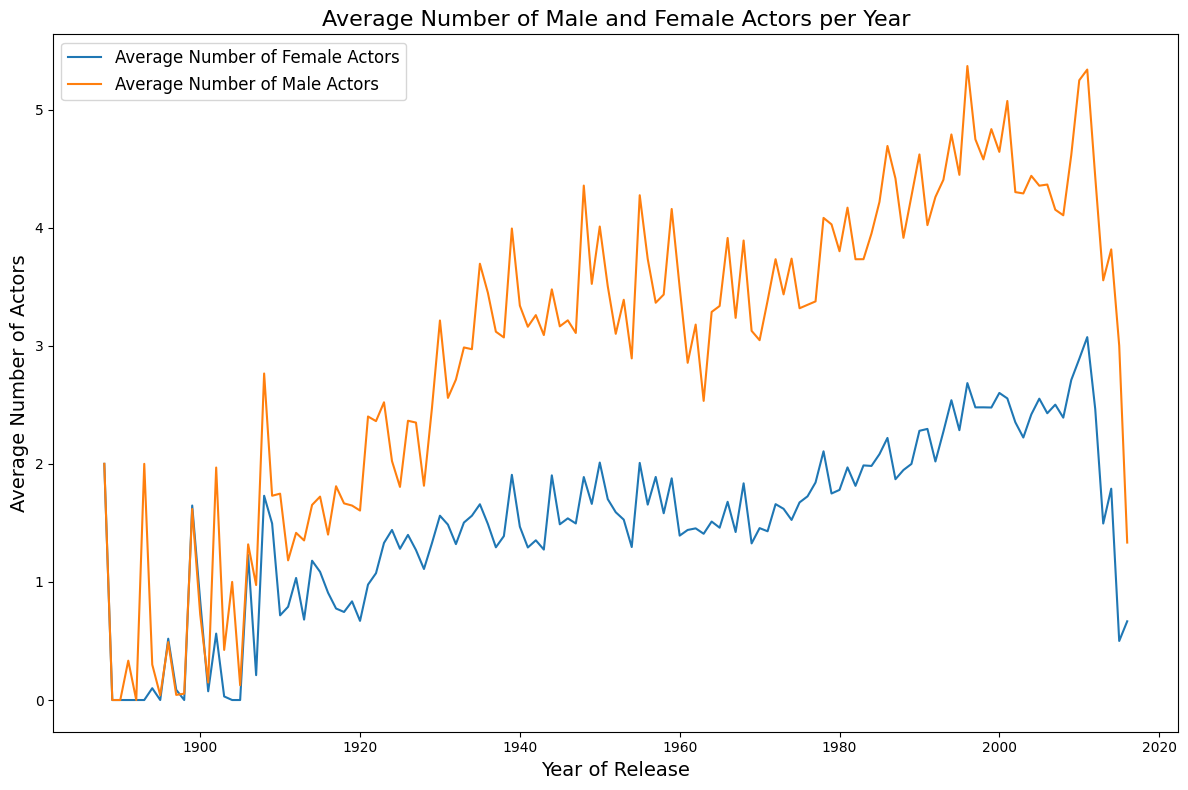

,wikipedia_movie_ID,freebase_movie_ID,name,release_date,revenue,runtime,languages,countries,genres,vote_average,vote_count,adult,budget,popularity,Character Count,Female actor count,Male actor count,N/A actor count,release_year
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",5.127,977,False,28000000,14.189,17,6,11,0,2001.0
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",0.0,0,False,0,0.6,15,4,11,0,2000.0
2,28463795,/m/0crgdbh,brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,NaN,NaN,NaN,NaN,4,2,2,0,1988.0
3,9363483,/m/0285_cd,white of the eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",5.742,64,False,0,8.297,2,1,1,0,1987.0
4,261236,/m/01mrr1,a woman in flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",5.3,13,False,0,2.801,3,1,2,0,1983.0


In [19]:
MOVIES['release_year'] = pd.to_datetime(MOVIES.release_date, errors='coerce').dt.year
#MOVIES['release_year'] = MOVIES['release_year'].fillna(0).astype(int)
MOVIES['release_year'] = MOVIES.apply(lambda row: int(row['release_date']) if isinstance(row['release_date'], str) and len(row['release_date']) == 4 else row['release_year'], axis=1)

# Vérifier que les valeurs sans date restent en NaN au lieu de 0
MOVIES['release_year'] = MOVIES['release_year'].replace(0, np.nan)


# Step 1: Extract the release year from the "movies release date" column
# Assuming the column name is "release_date" and is formatted as a string with "YYYY-MM-DD"
#MOVIES['release_year'] = pd.to_datetime(MOVIES['release_date'], errors='coerce').dt.year

# Step 2: Group by release year and calculate the average number of male and female actors
average_actors_by_year = MOVIES.groupby('release_year')[['Female actor count', 'Male actor count']].mean()

# Step 3: Plot the results
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the average number of male and female actors by year
average_actors_by_year.plot(ax=ax)

# Customize the plot with title and labels
ax.set_title("Average Number of Male and Female Actors per Year", fontsize=16)
ax.set_xlabel("Year of Release", fontsize=14)
ax.set_ylabel("Average Number of Actors", fontsize=14)
ax.legend(["Average Number of Female Actors", "Average Number of Male Actors"], fontsize=12)



# Show the plot
plt.tight_layout()
plt.show()

MOVIES.head()

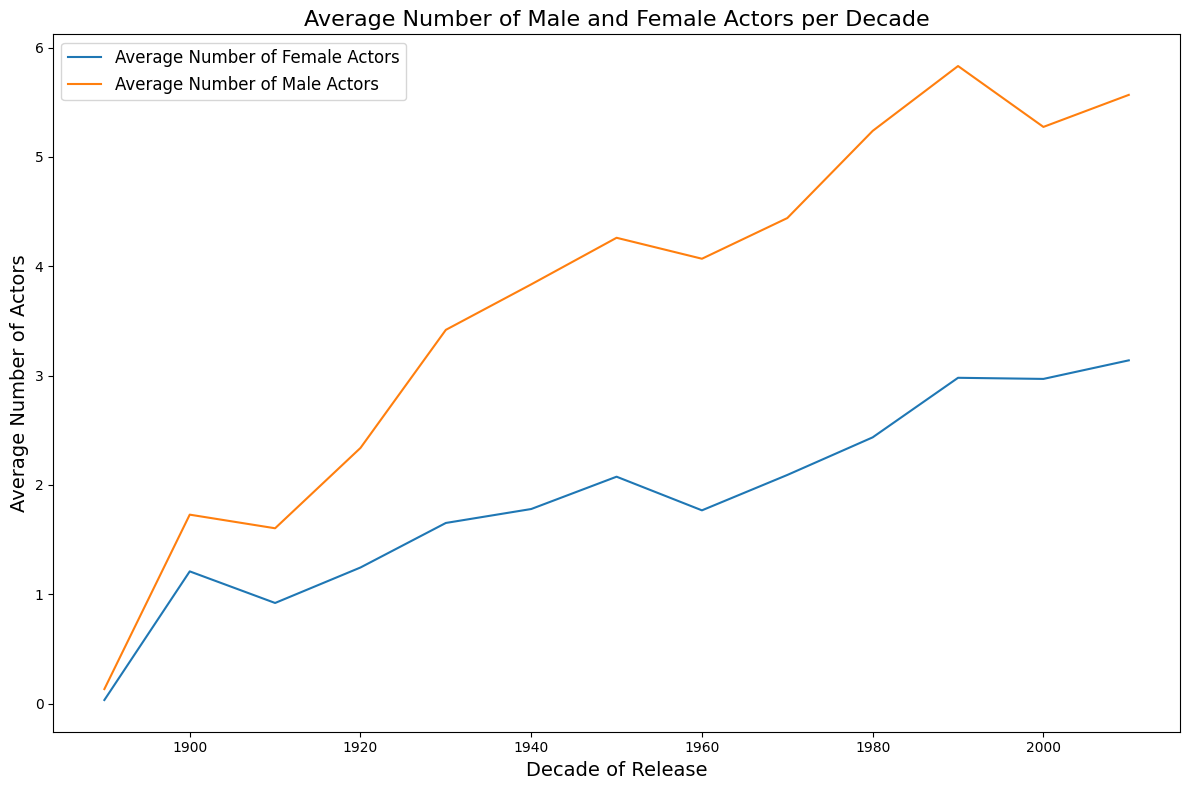

In [21]:
# Step 1: Extract the release year from the "movies release date" column
# Assuming the column name is "release_date" and is formatted as a string with "YYYY-MM-DD"
#MOVIES['release_year'] = pd.to_datetime(MOVIES['release_date'], errors='coerce').dt.year

# Step 2: Convert the release year to the corresponding decade
MOVIES['release_decade'] = (MOVIES['release_year'] // 10) * 10

# Step 3: Group by release decade and calculate the average number of male and female actors
average_actors_by_decade = MOVIES.groupby('release_decade')[['Female actor count', 'Male actor count']].mean()

# Step 4: Plot the results
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the average number of male and female actors by decade
average_actors_by_decade.plot(ax=ax)

# Customize the plot with title and labels
ax.set_title("Average Number of Male and Female Actors per Decade", fontsize=16)
ax.set_xlabel("Decade of Release", fontsize=14)
ax.set_ylabel("Average Number of Actors", fontsize=14)
ax.legend(["Average Number of Female Actors", "Average Number of Male Actors"], fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


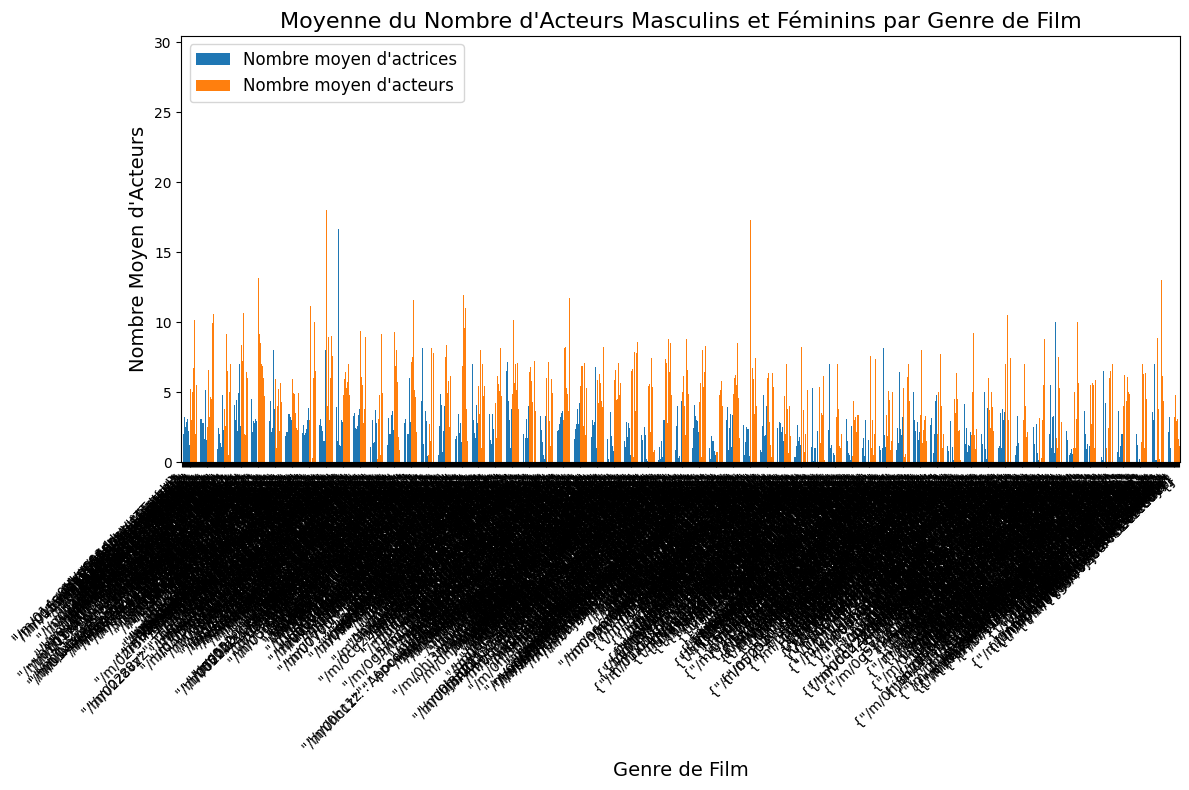

In [22]:
#BE CAREFUL CHANGE THE CODE PART WITH THE GENRE
# # Étape 1 : Séparer les genres en lignes distinctes pour chaque genre de film
# Supposons que la colonne 'genres' contient une chaîne de texte avec les genres séparés par des virgules
MOVIES_GENRES = MOVIES.assign(genres=MOVIES['genres'].str.split(',')).explode('genres')

# Étape 2 : Supprimer les espaces autour des noms de genres pour éviter des doublons causés par des espaces
MOVIES_GENRES['genres'] = MOVIES_GENRES['genres'].str.strip()

# Étape 3 : Calculer la moyenne du nombre d'acteurs masculins et féminins par genre
average_actors_by_genre = MOVIES_GENRES.groupby('genres')[['Female actor count', 'Male actor count']].mean()
average_actors_by_genre.head()

# Création du graphique en barres pour visualiser la moyenne du nombre d'acteurs par genre
fig, ax = plt.subplots(figsize=(12, 8))

# Graphiques pour les acteurs masculins et féminins
average_actors_by_genre.plot(kind='bar', ax=ax, width=0.8)

# Configuration des titres et étiquettes
ax.set_title("Moyenne du Nombre d'Acteurs Masculins et Féminins par Genre de Film", fontsize=16)
ax.set_xlabel("Genre de Film", fontsize=14)
ax.set_ylabel("Nombre Moyen d'Acteurs", fontsize=14)
ax.legend(["Nombre moyen d'actrices", "Nombre moyen d'acteurs"], fontsize=12)

# Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')

# Afficher le graphique
plt.tight_layout()
plt.show()
# compraison of the results

In [14]:
MOVIES.columns

Index(['wikipedia_movie_ID', 'freebase_movie_ID', 'name', 'release_date',
       'revenue', 'runtime', 'languages', 'countries', 'genres',
       'vote_average', 'vote_count', 'adult', 'budget', 'popularity',
       'Wikipedia movie ID_x', 'Number of Female', 'Number of Male',
       'Wikipedia movie ID_y', 'Character Count', 'release_year',
       'release_decade'],
      dtype='object')

In [15]:
print(len(MOVIES_ORIGINAL["name"].unique()))
print(len(MOVIES_NEW["title"].unique()))
print(len(MOVIES["name"].unique()))
print(len(MOVIES))

75378
958661
75378
227004


# DATA WRANGLING

- NANs
- Non sense values
  ...

### Release date to year

In [16]:
if "release_date" in MOVIES.columns:
    MOVIES["release_year"] = pd.to_datetime(MOVIES['release_date'], errors='coerce').dt.year
    
MOVIES["release_year"] = MOVIES["release_year"].fillna(0).astype(int)
MOVIES["release_year"]

0         2001
1         2000
2            0
3            0
4            0
          ... 
226999    2011
227000    2011
227001    1972
227002    1992
227003       0
Name: release_year, Length: 227004, dtype: int64

### Runtime to float

In [17]:
MOVIES["runtime"] = MOVIES["runtime"].fillna(0).astype(float)
MOVIES["runtime"]

0          98.0
1          95.0
2          83.0
3         110.0
4         106.0
          ...  
226999     96.0
227000     96.0
227001     66.0
227002    150.0
227003     86.0
Name: runtime, Length: 227004, dtype: float64

### Remove outliers, wrong values and NaNs from years

In [18]:
FIRST_MOVIE_YEAR = 1888
ACTUAL_YEAR = 2024
# MOVIES = MOVIES[MOVIES["status"] == "Released"]
MOVIES = MOVIES[(MOVIES["release_year"] >= FIRST_MOVIE_YEAR) & (MOVIES["release_year"] <= ACTUAL_YEAR) & (MOVIES["release_year"] != 0)]
MOVIES = MOVIES[(MOVIES["runtime"] >= 40) & (MOVIES["runtime"] <= 200)]


print(f'Fist year: {MOVIES["release_year"].min()}, Last year: {MOVIES["release_year"].max()}')

Fist year: 1906, Last year: 2013


# Data analysis

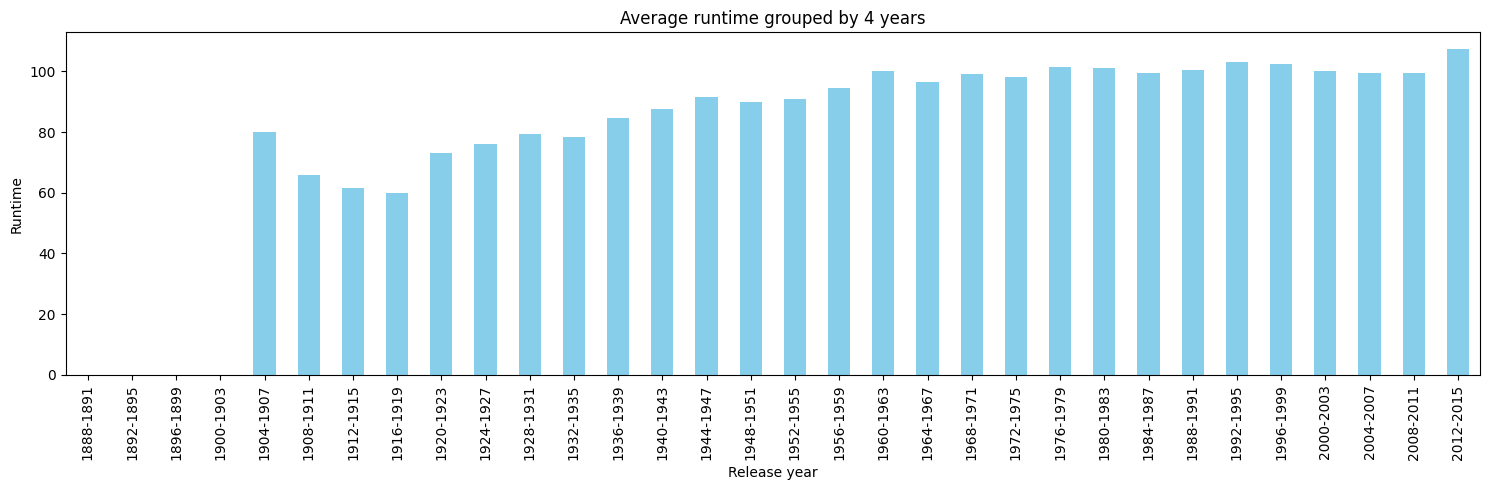

In [19]:
movies_year_runtime = MOVIES.groupby("release_year")["runtime"].median()

bin_size = 4

binned_runtimes = {}

for i in range(FIRST_MOVIE_YEAR, int(movies_year_runtime.index.max()), bin_size):
    bin_start, bin_end = i, i + bin_size - 1
    
    # Calculate the mean runtime within the current year range (bin)
    total_in_bin = movies_year_runtime[
        (movies_year_runtime.index >= bin_start) & 
        (movies_year_runtime.index <= bin_end)
    ].median()
    
    # Store result in dictionary with bin label as key
    binned_runtimes[f'{bin_start}-{bin_end}'] = total_in_bin

binned_token_counts = pd.Series(binned_runtimes)

# Plot
plt.figure(figsize=(15, 5))
binned_token_counts.plot(kind='bar', color='skyblue')

plt.xlabel('Release year')
plt.ylabel('Runtime')
plt.title(f'Average runtime grouped by {bin_size} years')

plt.tight_layout()
plt.show()

### Genre

In [20]:
import seaborn as sns
import ast
from collections import Counter

In [21]:
MOVIES["genres"] = MOVIES["genres"].apply(lambda x: list(ast.literal_eval(x).values()))

20


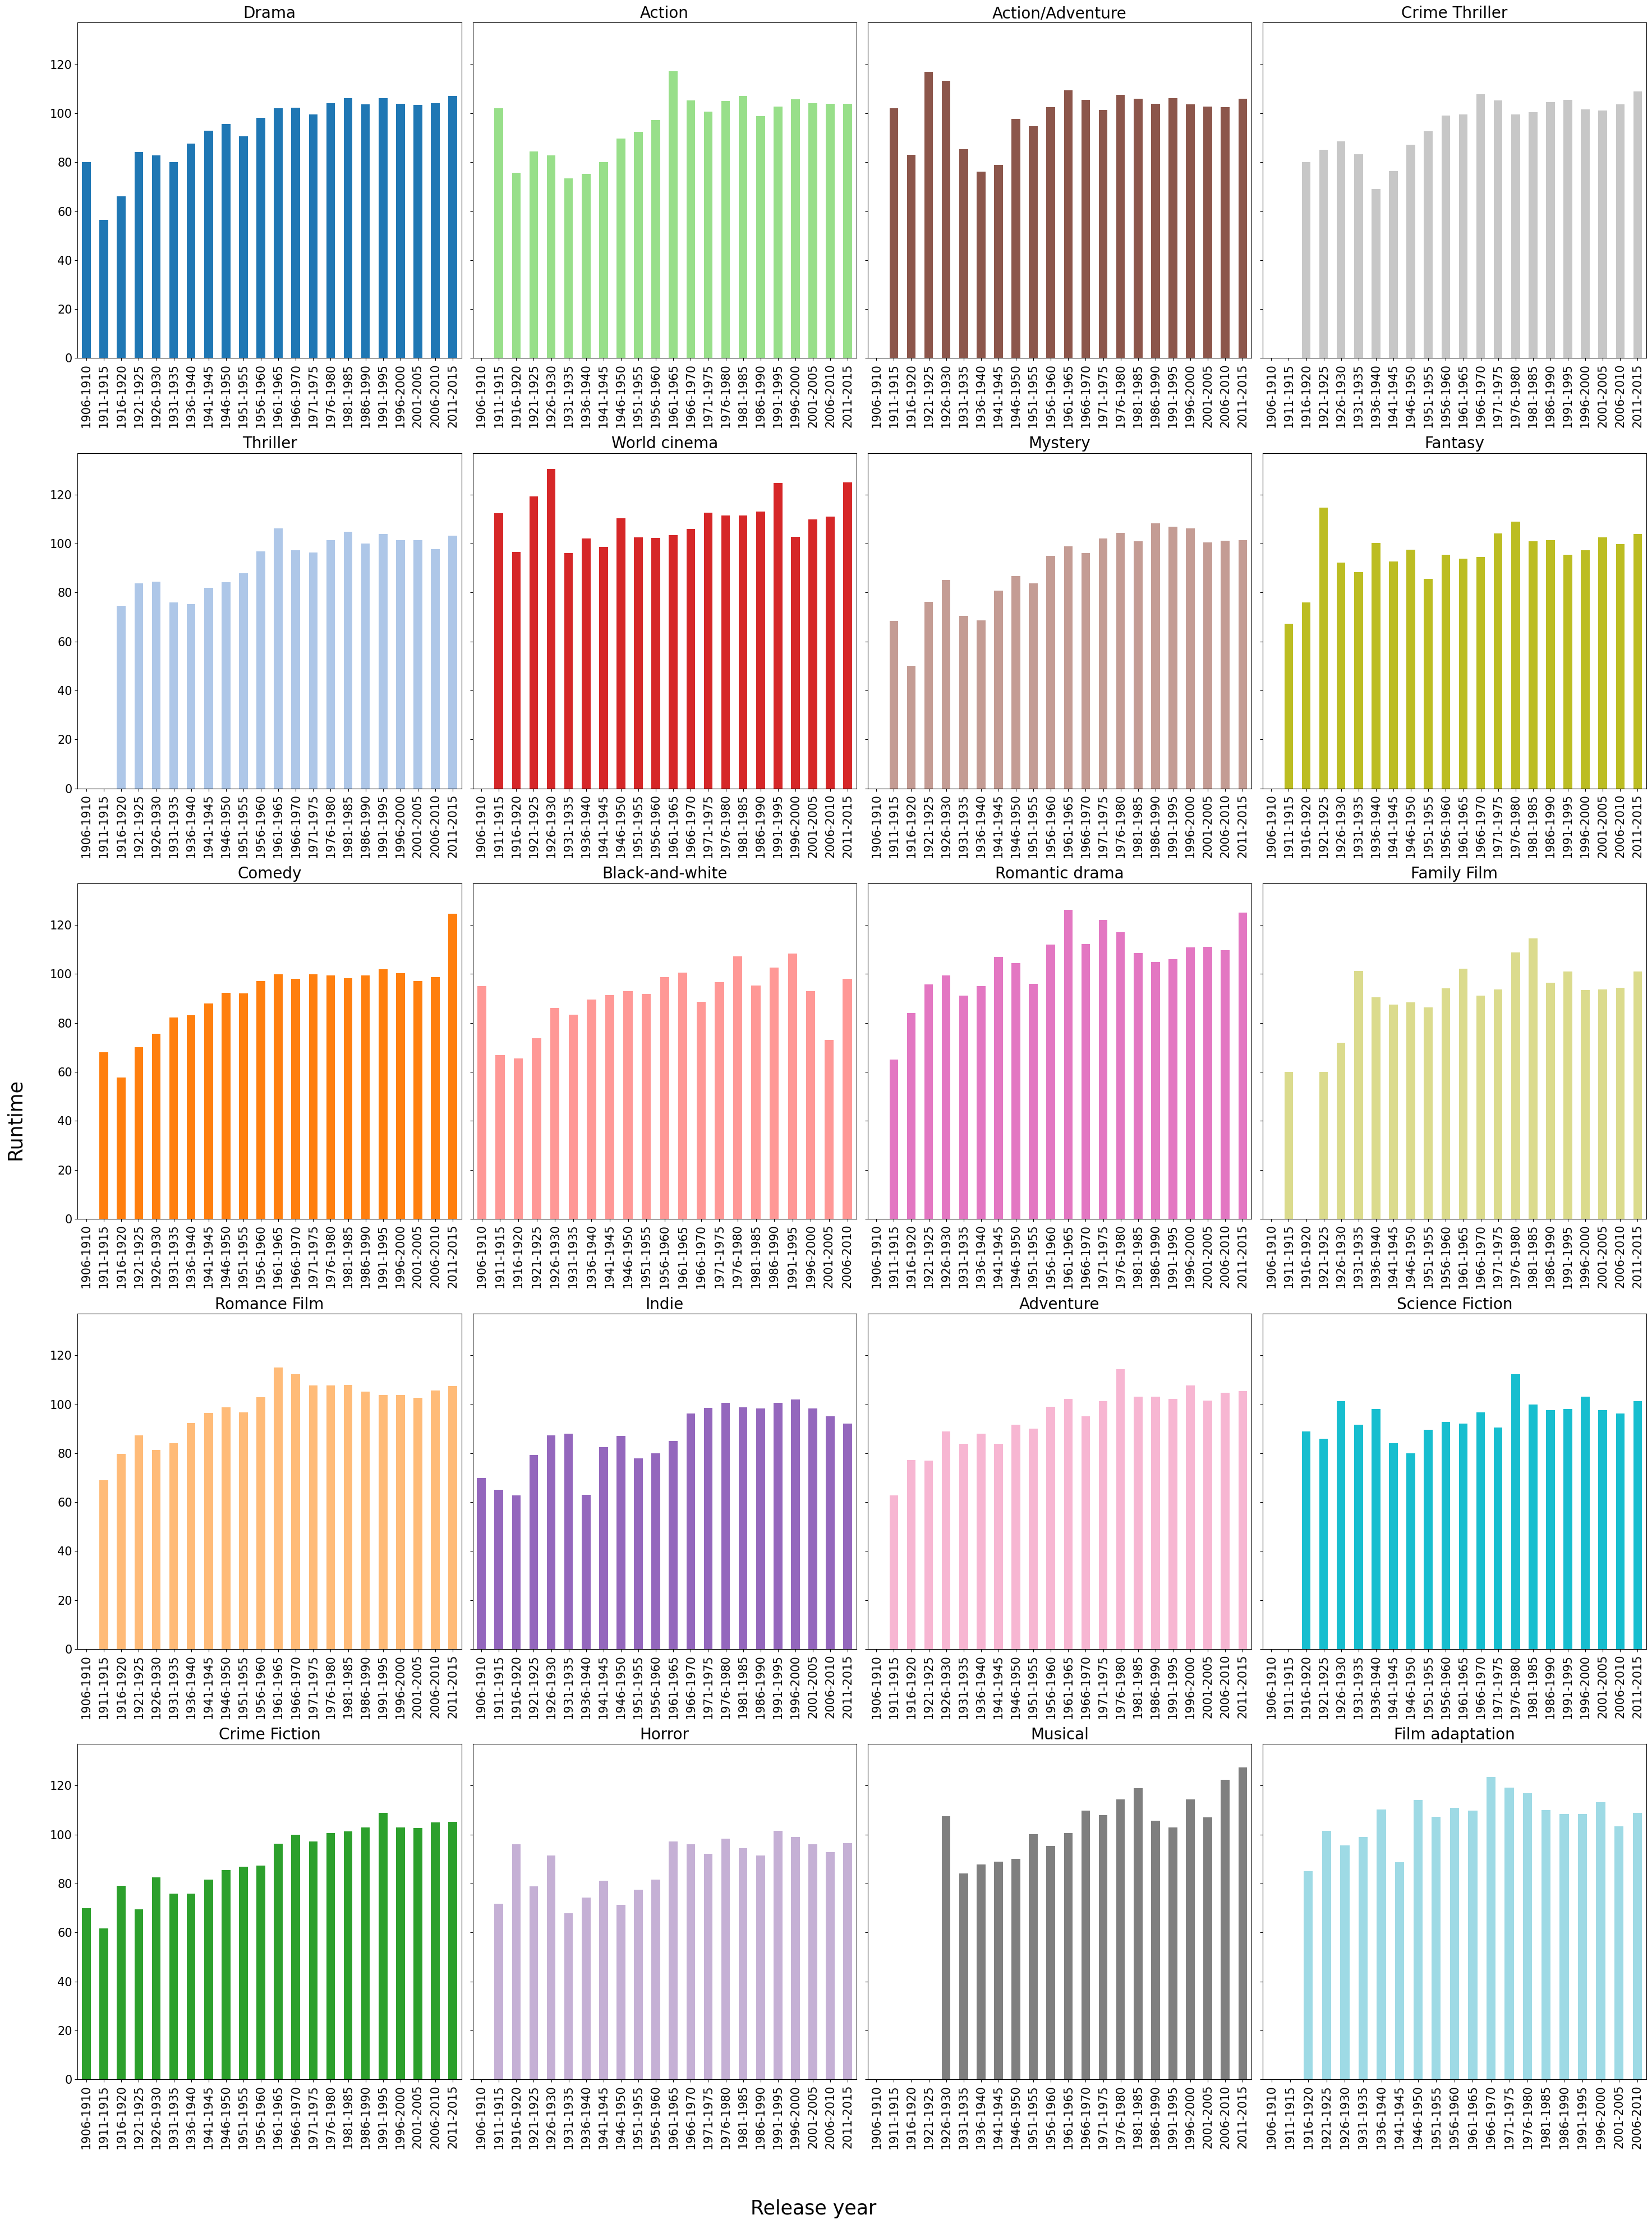

In [22]:
unique_genre = list()
MOVIES["genres"].apply(lambda x: unique_genre.extend(x))
unique_genre = Counter(unique_genre)

unique_genre = {k: v for k, v in sorted(unique_genre.items(), key=lambda item: item[1], reverse=True)}
unique_genre = {k: unique_genre[k] for k in list(unique_genre)[:20]}
#unique_genre = {x:unique_genre[x] for x in unique_genre if unique_genre[x] >= 300}
print(len(unique_genre))

fig, axes = plt.subplots(5, 4, figsize=(30, 40), sharey = True)
#fig.delaxes(axes[4, 3])
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

for j, genre in enumerate(unique_genre):

    filtered_df = MOVIES[MOVIES["genres"].apply(lambda x: genre in x)]
    bin_size = 5
    movies_year_runtime = filtered_df.groupby("release_year")["runtime"].median()
    binned_counts = {}

    for i in range(MOVIES["release_year"].min(), movies_year_runtime.index.max(), bin_size):
        bin_start, bin_end = i, i + bin_size - 1
        
        # Sum all the runtimes counts in this range.
        total_in_bin = movies_year_runtime[(movies_year_runtime.index >= bin_start) & (movies_year_runtime.index <= bin_end)].mean()
        
        binned_counts[f'{bin_start}-{bin_end}'] = total_in_bin


    binned_token_counts = pd.Series(binned_counts)
    color = next(color_iter)
    ax = axes[j%5, j//5]
    binned_token_counts.plot(kind='bar', ax=ax, color=color, fontsize=15)

    ax.set_title(genre, size = 20)
fig.supxlabel('Release year', size = 25)
fig.supylabel('Runtime', size = 25)
fig.tight_layout(rect=(0.025,0.025,1,1))

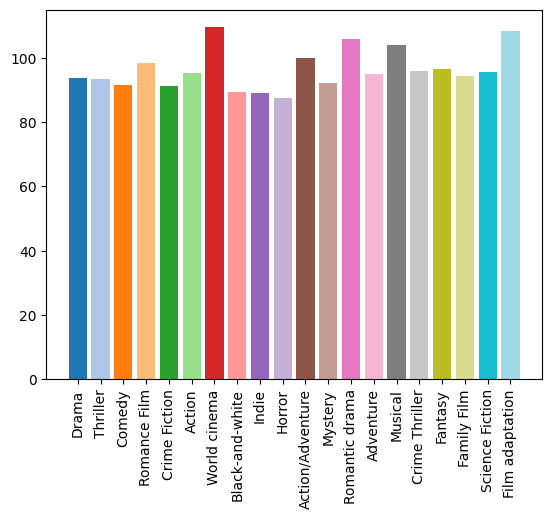

In [23]:
fig, ax = plt.subplots()
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)
average = []
number_of_year_to_average = 5

for idx, genre in enumerate(unique_genre):

    filtered_df = MOVIES[MOVIES["genres"].apply(lambda x: genre in x)]
    average.append(filtered_df.groupby("release_year")["runtime"].median().mean())
    
ax.tick_params(axis='x', labelrotation=90)
for i in range(len(unique_genre)):
    color = next(color_iter)
    ax.bar(list(unique_genre.keys())[i], average[i], color=color)

# Character managment

In [24]:
vgh

NameError: name 'vgh' is not defined

# ML MODEL: Predicting

In [342]:
import random
import torch
from torchvision import datasets, transforms

ModuleNotFoundError: No module named 'torchvision'

### Model definition

In [ ]:
get_model = lambda feature_size, genre_size, layer_size: torch.nn.Sequential(
    # Input layer
    torch.nn.Linear(feature_size, layer_size),
    torch.nn.ReLU(),
    
    # Hidden layers
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    
    # Output layer
    torch.nn.Linear(layer_size, genre_size),
    torch.nn.Sigmoid()
)

### Model instance

In [ ]:
genre_size = 30
feature_size = 30

model_factory = lambda: get_model(feature_size, genre_size, SETTINGS["MODEL_SETTINGS"]["LAYER_SIZE"])
model = model_factory()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device=device)

optimizer_kwargs = dict(
    lr=3e-4,
    weight_decay=1e-3,
)
optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)

### Model training

In [ ]:
def train_model(batches_train, batches_test, model, optimizer, classification_threshold, device):
    # Set model to training mode 
    model.train()

    loss_history = []
    accuracy_history = []
    # Change the loop to get batch_idx, data and target from train_loader
    for sample_i, (data, target) in enumerate(zip(batches_train, batches_test)):
        N = data.shape[0] 
        Dy = target.shape[1] # Number of possible genre 
        
        # Move the data to the device
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = torch.nn.BCELoss()(output, target)
        loss_float = loss.item()
        # Backpropagate loss & Perform an optimizer step
        loss.backward()
        optimizer.step()
        
        
        # Compute accuracy and loss of the batch
        output_hot = (output > classification_threshold).int() # we have |N| x |genre| matrix
        correct = torch.sum(output_hot == target)
        accuracy = correct.item() / (N * Dy) 
        """Maybe use precision"""
        
        accuracy_history.append(accuracy)
        loss_history.append(loss_float)
        
        if sample_i % 1000 == 0:
            print(f'Batch loss = {loss_float:0.2e}')
            print(f'Batch accuracy = {accuracy:0.3f}')
    # print(f"{loss_history = }, {accuracy_history = }")
    return model, loss_history, accuracy_history

In [ ]:
def get_training_batch(training_set, target_set, batch_size = 10):
    assert len(training_set) == len(target_set), "Lists must be of equal length."
    
    batches_train = []
    batches_test = []
    for i in range(0, len(training_set), batch_size):
        # batches_train.append(training_set[i:i+batch_size])
        # batches_test.append(target_set[i:i+batch_size])
        batches_train.append(torch.tensor(training_set[i:i+batch_size]))
        batches_test.append(torch.tensor(target_set[i:i+batch_size]))
        
    return batches_train, batches_test

In [ ]:
training_set = []
target_set = []
batches_train, batches_test = get_training_batch(training_set, target_set)

trained_model, train_loss, train_acc, lrs = train_model(
    batches_train, batches_test, model, optimizer, SETTINGS["MODEL_SETTINGS"]["GENRE_THRESHOLD"], device
) 

In [ ]:
training_set = [i for i in range(1, 105)]
target_set = [i**2 for i in range(1, 105)]


batches_train, batches_test = get_training_batch(training_set, target_set)

print(batches_train, batches_test)

for sample_i, (data, target) in enumerate(zip(batches_train, batches_test)):
     print(f"\n\n{sample_i = }")
     print(f"{data = }")
     print(f"{target = }")

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [21, 22, 23, 24, 25, 26, 27, 28, 29, 30], [31, 32, 33, 34, 35, 36, 37, 38, 39, 40], [41, 42, 43, 44, 45, 46, 47, 48, 49, 50], [51, 52, 53, 54, 55, 56, 57, 58, 59, 60], [61, 62, 63, 64, 65, 66, 67, 68, 69, 70], [71, 72, 73, 74, 75, 76, 77, 78, 79, 80], [81, 82, 83, 84, 85, 86, 87, 88, 89, 90], [91, 92, 93, 94, 95, 96, 97, 98, 99, 100], [101, 102, 103, 104]] [[1, 4, 9, 16, 25, 36, 49, 64, 81, 100], [121, 144, 169, 196, 225, 256, 289, 324, 361, 400], [441, 484, 529, 576, 625, 676, 729, 784, 841, 900], [961, 1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600], [1681, 1764, 1849, 1936, 2025, 2116, 2209, 2304, 2401, 2500], [2601, 2704, 2809, 2916, 3025, 3136, 3249, 3364, 3481, 3600], [3721, 3844, 3969, 4096, 4225, 4356, 4489, 4624, 4761, 4900], [5041, 5184, 5329, 5476, 5625, 5776, 5929, 6084, 6241, 6400], [6561, 6724, 6889, 7056, 7225, 7396, 7569, 7744, 7921, 8100], [8281, 8464, 8649, 8836, 9025, 9216, 9409, 9604, 